# Machine Learning Engineer Nanodegree

## Capstone Project

### Inspired by the [Animal Shelter Outcome](https://www.kaggle.com/c/shelter-animal-outcomes) competition in Kaggle

In [103]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from time import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC 
from sklearn.tree import DecisionTreeClassifier

%matplotlib inline

In [2]:
# Force floating point division
from __future__ import division

In [3]:
# Read train data (to be used for both training and testing locally)
raw_data = pd.read_csv("data/train.csv")
print raw_data.head()

  AnimalID     Name             DateTime      OutcomeType OutcomeSubtype  \
0  A671945  Hambone  2014-02-12 18:22:00  Return_to_owner            NaN   
1  A656520    Emily  2013-10-13 12:44:00       Euthanasia      Suffering   
2  A686464   Pearce  2015-01-31 12:28:00         Adoption         Foster   
3  A683430      NaN  2014-07-11 19:09:00         Transfer        Partner   
4  A667013      NaN  2013-11-15 12:52:00         Transfer        Partner   

  AnimalType SexuponOutcome AgeuponOutcome                        Breed  \
0        Dog  Neutered Male         1 year        Shetland Sheepdog Mix   
1        Cat  Spayed Female         1 year       Domestic Shorthair Mix   
2        Dog  Neutered Male        2 years                 Pit Bull Mix   
3        Cat    Intact Male        3 weeks       Domestic Shorthair Mix   
4        Dog  Neutered Male        2 years  Lhasa Apso/Miniature Poodle   

         Color  
0  Brown/White  
1  Cream Tabby  
2   Blue/White  
3   Blue Cream  
4      

## Training Considerations

### Features/columns to be considered

- OutcomeType
- AnimalType
- SexuponOutcome
- AgeuponOutcome
- Breed 
- Color

### Features/columns to be ignored

- AnimalID: this is for internal use only.
- Name: this is probably not relevant to predict the animal's outcome.
- DateTime: this is only relevant for when the train data was captured, yet irrelevant for future predictions. Plus, it would be imposible to know when in the future the to-be-predicted outcome will take place.
- OutcomeSubtype: this is outside of the project scope.

## Data Cleanup

In [4]:
# Remove ignored features/columns
train_data = raw_data.drop(['AnimalID', 'Name', 'DateTime', 'OutcomeSubtype'], axis=1)
print train_data.head()

       OutcomeType AnimalType SexuponOutcome AgeuponOutcome  \
0  Return_to_owner        Dog  Neutered Male         1 year   
1       Euthanasia        Cat  Spayed Female         1 year   
2         Adoption        Dog  Neutered Male        2 years   
3         Transfer        Cat    Intact Male        3 weeks   
4         Transfer        Dog  Neutered Male        2 years   

                         Breed        Color  
0        Shetland Sheepdog Mix  Brown/White  
1       Domestic Shorthair Mix  Cream Tabby  
2                 Pit Bull Mix   Blue/White  
3       Domestic Shorthair Mix   Blue Cream  
4  Lhasa Apso/Miniature Poodle          Tan  


## Data exploration

In [5]:
n_cols = len(train_data.columns)
n_rows = len(train_data)

print "Number of columns: {0}".format(n_cols)
print "Number of columns: {0}".format(n_rows)

Number of columns: 6
Number of columns: 26729


In [6]:
train_data.describe()

,OutcomeType,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
count,26729,26729,26728,26711,26729,26729
unique,5,2,5,44,1380,366
top,Adoption,Dog,Neutered Male,1 year,Domestic Shorthair Mix,Black/White
freq,10769,15595,9779,3969,8810,2824


In [7]:
animaltype_groupby = train_data.groupby('AnimalType')
animaltype_groupby.describe()

AgeuponOutcome                   Breed        Color  \
AnimalType                                                              
Cat        count           11117                   11134        11134   
           unique             44                      60          146   
           top          2 months  Domestic Shorthair Mix  Brown Tabby   
           freq             2220                    8810         1635   
Dog        count           15594                   15595        15595   
           unique             43                    1320          262   
           top           2 years            Pit Bull Mix  Black/White   
           freq             2818                    1906         1730   

                  OutcomeType SexuponOutcome  
AnimalType                                    
Cat        count        11134          11134  
           unique           5              5  
           top       Transfer  Neutered Male  
           freq          5505           3065  
Dog        count        15595          15594  
           unique           5              5  
           top       Adoption  Neutered Male  
           freq          6497           6714

In [8]:
breed_groupby = train_data.groupby('Breed')
breed_groupby.describe()

AgeuponOutcome AnimalType  \
Breed                                                                       
Abyssinian Mix                           count               2          2   
                                         unique              2          1   
                                         top            1 year        Cat   
                                         freq                1          2   
Affenpinscher Mix                        count               6          6   
                                         unique              4          1   
                                         top            1 year        Dog   
                                         freq                2          6   
Afghan Hound Mix                         count               1          1   
                                         unique              1          1   
                                         top           2 years        Dog   
                                         freq                1          1   
Airedale Terrier                         count               1          1   
                                         unique              1          1   
                                         top           6 years        Dog   
                                         freq                1          1   
Airedale Terrier Mix                     count               5          5   
                                         unique              5          1   
                                         top           6 years        Dog   
                                         freq                1          5   
Airedale Terrier/Labrador Retriever      count               1          1   
                                         unique              1          1   
                                         top           4 years        Dog   
                                         freq                1          1   
Airedale Terrier/Miniature Schnauzer     count               1          1   
                                         unique              1          1   
                                         top           1 month        Dog   
                                         freq                1          1   
Akita                                    count               3          3   
                                         unique              2          1   
...                                                        ...        ...   
Yorkshire Terrier/Maltese                top           3 years        Dog   
                                         freq                2          4   
Yorkshire Terrier/Miniature Poodle       count              12         12   
                                         unique              8          1   
                                         top           4 years        Dog   
                                         freq                3         12   
Yorkshire Terrier/Miniature Schnauzer    count               8          8   
                                         unique              5          1   
                                         top           2 years        Dog   
                                         freq                3          8   
Yorkshire Terrier/Norfolk Terrier        count               1          1   
                                         unique              1          1   
                                         top           4 years        Dog   
                                         freq                1          1   
Yorkshire Terrier/Parson Russell Terrier count               1          1   
                                         unique              1          1   
                                         top           3 years        Dog   
                                         freq                1          1   
Yorkshire Terrier/Pomeranian             count               1          1   
                                         uni

##### NOTES

- There seems to be a ton of unique breeds (1380) as compared to the "uniqueness" of other features. The previous table suggests a lot of them have 1 or 2 unique values only. This could be troublesome when wanting to obtain useful trends for predictions, since there may not be enough data for those breeds to extract useful information. We may want to "group" them in a higher level of categorization in order to extract more useful info. E.g., we could group all Yorkshire breeds into a single breed.  

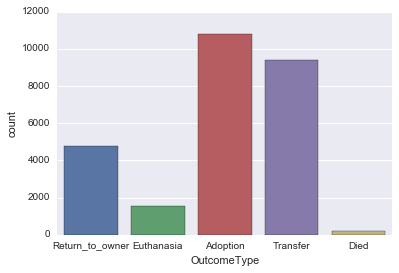

In [9]:
sns.countplot(train_data['OutcomeType'])

In [10]:
outcometype_groupby = train_data.groupby('OutcomeType')
outcometype_groupby.describe()

AgeuponOutcome AnimalType                   Breed  \
OutcomeType                                                                
Adoption        count           10769      10769                   10769   
                unique             28          2                     920   
                top          2 months        Dog  Domestic Shorthair Mix   
                freq             2636       6497                    3273   
Died            count             197        197                     197   
                unique             31          2                      35   
                top           1 month        Cat  Domestic Shorthair Mix   
                freq               48        147                     112   
Euthanasia      count            1553       1555                    1555   
                unique             39          2                     198   
                top           2 years        Dog  Domestic Shorthair Mix   
                freq              275        845                     535   
Return_to_owner count            4786       4786                    4786   
                unique             35          2                     639   
                top           2 years        Dog            Pit Bull Mix   
                freq              917       4286                     598   
Transfer        count            9406       9422                    9422   
                unique             41          2                     623   
                top            1 year        Cat  Domestic Shorthair Mix   
                freq             1417       5505                    4538   

                              Color SexuponOutcome  
OutcomeType                                         
Adoption        count         10769          10769  
                unique          260              4  
                top     Black/White  Neutered Male  
                freq           1183           5222  
Died            count           197            197  
                unique           48              5  
                top     Black/White    Intact Male  
                freq             27             79  
Euthanasia      count          1555           1555  
                unique          137              5  
                top     Black/White    Intact Male  
                freq            160            477  
Return_to_owner count          4786           4785  
                unique          212              5  
                top     Black/White  Neutered Male  
                freq            474           2247  
Transfer        count          9422           9422  
                unique          241              5  
                top     Black/White  Intact Female  
                freq            980           2550

In [11]:
train_data["OutcomeType"].value_counts()

Adoption           10769
Transfer            9422
Return_to_owner     4786
Euthanasia          1555
Died                 197
Name: OutcomeType, dtype: int64

## Data Preparation

##### Extract feature/target cols

In [12]:
# Extract feature columns
X_all = train_data.drop(['OutcomeType'], axis=1)
feature_cols = list(X_all.columns)

# Extract target column 'OutcomeType'
y_all = train_data.drop(X_all.columns, axis=1)
target_col = y_all.columns

# Show the list of columns
print "Feature columns:\n{}".format(feature_cols)
print "\nTarget column: {}\n".format(target_col)

print "X_all head:"
print X_all.head()

print "\ny_all head:"
print y_all.head()

Feature columns:
['AnimalType', 'SexuponOutcome', 'AgeuponOutcome', 'Breed', 'Color']

Target column: Index([u'OutcomeType'], dtype='object')

X_all head:
  AnimalType SexuponOutcome AgeuponOutcome                        Breed  \
0        Dog  Neutered Male         1 year        Shetland Sheepdog Mix   
1        Cat  Spayed Female         1 year       Domestic Shorthair Mix   
2        Dog  Neutered Male        2 years                 Pit Bull Mix   
3        Cat    Intact Male        3 weeks       Domestic Shorthair Mix   
4        Dog  Neutered Male        2 years  Lhasa Apso/Miniature Poodle   

         Color  
0  Brown/White  
1  Cream Tabby  
2   Blue/White  
3   Blue Cream  
4          Tan  

y_all head:
       OutcomeType
0  Return_to_owner
1       Euthanasia
2         Adoption
3         Transfer
4         Transfer


##### Preprocess columns to make them quantifiable

In [13]:
def process_data(D):
    ''' Converts categorical variables into dummy variables. '''
    
    # Initialize new output DataFrame
    output = pd.DataFrame(index = D.index)

    # Investigate each feature column for the data
    for col, col_data in D.iteritems():
        
        # If data type is categorical, convert to dummy variables
        if col_data.dtype == object:
            # Example: 'AgeuponOutcome' => 'AgeuponOutcome_3 weeks' ...
            col_data = pd.get_dummies(col_data, prefix = col)  
        
        # Collect the revised columns
        output = output.join(col_data)
    
    return output

In [14]:
X_all_processed = process_data(X_all)
print "Processed feature columns ({} total features):\n{}".format(len(X_all_processed.columns), list(X_all_processed.columns))
print X_all_processed.head()

Processed feature columns (1797 total features):
['AnimalType_Cat', 'AnimalType_Dog', 'SexuponOutcome_Intact Female', 'SexuponOutcome_Intact Male', 'SexuponOutcome_Neutered Male', 'SexuponOutcome_Spayed Female', 'SexuponOutcome_Unknown', 'AgeuponOutcome_0 years', 'AgeuponOutcome_1 day', 'AgeuponOutcome_1 month', 'AgeuponOutcome_1 week', 'AgeuponOutcome_1 weeks', 'AgeuponOutcome_1 year', 'AgeuponOutcome_10 months', 'AgeuponOutcome_10 years', 'AgeuponOutcome_11 months', 'AgeuponOutcome_11 years', 'AgeuponOutcome_12 years', 'AgeuponOutcome_13 years', 'AgeuponOutcome_14 years', 'AgeuponOutcome_15 years', 'AgeuponOutcome_16 years', 'AgeuponOutcome_17 years', 'AgeuponOutcome_18 years', 'AgeuponOutcome_19 years', 'AgeuponOutcome_2 days', 'AgeuponOutcome_2 months', 'AgeuponOutcome_2 weeks', 'AgeuponOutcome_2 years', 'AgeuponOutcome_20 years', 'AgeuponOutcome_3 days', 'AgeuponOutcome_3 months', 'AgeuponOutcome_3 weeks', 'AgeuponOutcome_3 years', 'AgeuponOutcome_4 days', 'AgeuponOutcome_4 months

##### Prepare test data for Kaggle submission

Since Kaggle's evaluation engine uses a different data set (than the one used for training), we need to make sure the columns between the train set and the Kaggle test set match. That way we can use the same "trained" classifier for both local-testing and Kaggle-testing predictions.

In [16]:
test_data_ids = test_data['ID']
test_data_values = test_data[['AnimalType', 'SexuponOutcome', 'AgeuponOutcome', 'Breed', 'Color']]

In [15]:
raw_test_data = pd.read_csv("data/test.csv")
test_data = raw_test_data.drop(['Name', 'DateTime'], axis=1) # Contains ID

In [17]:
test_data_processed = process_data(test_data_values)
# print test_data_processed.head()

In [19]:
# If these differ, we need to adjust the Kaggle test data columns 
# and the training data columns to match so that the classifier works properly
print "Number of columns in train set: {0}".format(len(X_all_processed.columns))
print "Number of columns in Kaggle test set: {0}".format(len(test_data_processed.columns))

Number of columns in train set: 1797
Number of columns in Kaggle test set: 1242


In [20]:
# Adjust columns between Kaggle test data set and train data set if needed
if len(X_all_processed) != len(test_data_processed):
    # Add missing columns in Kaggle test data
    for column in X_all_processed.columns:
        if column not in test_data_processed:
            test_data_processed[column] = 0
            
    # Add missing columns in train data
    for column in test_data_processed.columns:
        if column not in X_all_processed:
            X_all_processed[column] = 0
    
    
    print "Should now match:"
    print "Number of columns in train set: {0}".format(len(X_all_processed.columns))
    print "Number of columns in Kaggle test set: {0}".format(len(test_data_processed.columns))    

Should now match:
Number of columns in train set: 2141
Number of columns in Kaggle test set: 2141


In [21]:
# Test that both Kaggle test data set and train data set columns have the same shape
assert len(X_all_processed.columns) == len(test_data_processed.columns)
for column in X_all_processed.columns:
    assert(column in test_data_processed)

In [115]:
def create_csv_for_kaggle_submission(clf, filepath):
    '''
    Saves a csv file ready for Kaggle submission, under the filepath specified
    '''
    
    # Make predictions based on Kaggle test data set
    kaggle_predictions = clf.predict_proba(test_data_processed)
    
    # Add animal IDs
    kaggle_predictions_with_id = np.copy(kaggle_predictions)
    kaggle_predictions_with_id = np.insert(kaggle_predictions_with_id, 0, 0, axis=1)
    for i, pred in enumerate(kaggle_predictions_with_id):
        pred[0] = np.int64(test_data_ids[i])
        kaggle_predictions_with_id[i] = pred

    # Prepend header
    header = np.insert(np.array(clf.classes_), 0, 'ID')
    kaggle_predictions_to_csv = np.vstack((header, kaggle_predictions_with_id))

    # Convert first column to int (since it's an ID)
    kaggle_predictions_to_csv.astype(object)
    for i, pred in enumerate(kaggle_predictions_to_csv):
        if i != 0:
            animalId = int(pred[0])
            pred[0] = animalId
            kaggle_predictions_to_csv[i] = pred
    
    # Save csv
    np.savetxt(filepath, kaggle_predictions_to_csv, delimiter=",", fmt="%s")

##### Split training/test data

We'll be doing local testing of our models before submitting them to Kaggle's evaluation engine for the final scores. To do this, we'll split the whole data set available in the `train.csv` file into training and testing data.

In [22]:
# TODO: Shuffle and split the dataset into the number of training and testing points above
X_train, X_test, y_train, y_test = train_test_split(X_all_processed, y_all, \
    test_size = .2, random_state = 5)

# Show the results of the split
print "Training set has {} samples.".format(X_train.shape[0])
print "Testing set has {} samples.".format(X_test.shape[0])

# Show first rows of train/test sets
print "\nX_train.head()"
print X_train.head()

print "\nX_test.head()"
print X_test.head()

print "\ny_train.head()"
print y_train.head()

print "\ny_test.head()"
print y_test.head()

Training set has 21383 samples.
Testing set has 5346 samples.

X_train.head()
       AnimalType_Cat  AnimalType_Dog  SexuponOutcome_Intact Female  \
5909                0               1                             0   
3806                0               1                             0   
3571                0               1                             0   
18840               1               0                             0   
15017               1               0                             0   

       SexuponOutcome_Intact Male  SexuponOutcome_Neutered Male  \
5909                            0                             1   
3806                            0                             1   
3571                            0                             1   
18840                           0                             0   
15017                           0                             0   

       SexuponOutcome_Spayed Female  SexuponOutcome_Unknown  \
5909                         

## Model Trainings and Evaluations

### Decision Tree (with probabilistic classification)

In [23]:
# Train
clf_dt = DecisionTreeClassifier(random_state=3)
clf_dt.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=3, splitter='best')

In [117]:
# Predict
y_pred = clf_dt.predict(X_test)
y_pred_proba = clf_dt.predict_proba(X_test)

In [118]:
print y_pred
print clf_dt.classes_
print y_pred_proba

['Transfer' 'Adoption' 'Return_to_owner' ..., 'Transfer' 'Adoption'
 'Adoption']
['Adoption' 'Died' 'Euthanasia' 'Return_to_owner' 'Transfer']
[[ 0.  0.  0.  0.  1.]
 [ 1.  0.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.]
 ..., 
 [ 0.  0.  0.  0.  1.]
 [ 1.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.]]


In [119]:
# Evaluate locally
print clf_dt.classes_
print "F1 score: {0}".format(f1_score(y_test, y_pred, average='macro'))
print "Log loss score: {0}".format(log_loss(y_test, y_pred_proba))

['Adoption' 'Died' 'Euthanasia' 'Return_to_owner' 'Transfer']
F1 score: 0.396904377227
Log loss score: 10.8781559704


In [100]:
# Evaluate in Kaggle engine
create_csv_for_kaggle_submission(clf_dt, 'kaggle/dt_prediction_1.csv')

### SVM (with probabilistic classification)

In [101]:
# Train
clf_svc = SVC(random_state=3, probability=True)
clf_svc.fit(X_train, y_train)

/Users/Rafael/Library/Miniconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=3, shrinking=True, tol=0.001,
  verbose=False)

In [111]:
# Predict
y_pred = clf_svc.predict(X_test)
y_pred_proba = clf_svc.predict_proba(X_test)

In [112]:
print y_pred
print clf_svc.classes_
print y_pred_proba

['Adoption' 'Adoption' 'Adoption' ..., 'Transfer' 'Adoption' 'Adoption']
['Adoption' 'Died' 'Euthanasia' 'Return_to_owner' 'Transfer']
[[ 0.60017071  0.00350208  0.03028751  0.2269063   0.1391334 ]
 [ 0.59012047  0.00360328  0.03304055  0.23367727  0.13955843]
 [ 0.35087365  0.00470498  0.04109922  0.48238764  0.12093451]
 ..., 
 [ 0.01263103  0.01877639  0.12709952  0.01328966  0.8282034 ]
 [ 0.59832797  0.00382849  0.03227802  0.22195229  0.14361322]
 [ 0.59662585  0.00284021  0.03191237  0.20955667  0.1590649 ]]


In [113]:
# Evaluate locally
print clf_svc.classes_
print "F1 score: {0}".format(f1_score(y_test, y_pred, average='macro'))
print "Log loss score: {0}".format(log_loss(y_test, y_pred_proba))

['Adoption' 'Died' 'Euthanasia' 'Return_to_owner' 'Transfer']
F1 score: 0.271978602934
Log loss score: 0.975607643905


/Users/Rafael/Library/Miniconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [116]:
# Evaluate in Kaggle engine
create_csv_for_kaggle_submission(clf_svc, 'kaggle/svc_prediction_1.csv')

## Models Tuning